# Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import imblearn
%matplotlib inline


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import imblearn
from imblearn.over_sampling import SMOTE
import os

# Read Data

In [4]:
data_path = os.path.join("dataset","Driverdatav1.csv")

In [5]:
df=pd.read_csv(data_path)

In [90]:
df.loc[df['Status']==0,:]

,OperClass,Gender,MilitaryService,Workhrdy,AGE,TrfTime,Status
10,E,F,N,6.2,56,0,0
16,E,M,N,6.4,41,0,0
17,E,M,Y,9.6,39,0,0
19,E,F,N,1.9,58,0,0
21,E,M,N,3.6,30,0,0
...,...,...,...,...,...,...,...
261,E,M,N,7.4,71,0,0
270,E,F,N,6.9,33,0,0
272,E,M,N,5.7,62,0,0
274,E,M,N,7.9,49,0,0


In [87]:
df.describe()

,Workhrdy,AGE,TrfTime,Status
count,315.000000,315.000000,315.000000,315.000000
mean,5.603492,45.028571,6.136508,0.660317
std,1.519393,11.331814,18.984668,0.474355
min,1.000000,23.000000,0.000000,0.000000
25%,4.800000,36.000000,0.000000,0.000000
50%,5.800000,45.000000,0.000000,1.000000
75%,6.500000,53.000000,0.000000,1.000000
max,9.600000,79.000000,154.000000,1.000000


# Identify Explained and Outcome Variable

# Split data into train and test dataset

In [8]:
from sklearn.model_selection import train_test_split
import pickle5 as pickle
import os

In [12]:
X = df.drop("Status",axis = 1)

In [14]:
y = df['Status']

In [16]:
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size= 0.25,random_state=259)

## Transformation Data PipeLine


In [21]:
from sklearn.preprocessing import StandardScaler
import pickle

In [26]:
numerical_columns = ['Workhrdy', 'AGE', 'TrfTime']

category_columns = ['OperClass', 'Gender', 'MilitaryService']
num_pipeline = Pipeline(steps=[("Scaler",StandardScaler())])
cat_pipeline = Pipeline(steps=[("one_hot_encoder",OneHotEncoder())])
processor = ColumnTransformer([("num_pipeline",num_pipeline,numerical_columns),
                               ("cat_pipeline",cat_pipeline,category_columns)],verbose_feature_names_out=False)

#Fit_transform the training set

transformed_X_train = processor.fit_transform(X_train)
transformed_X_test = processor.transform(X_test)
#Save the tranformation data file
with open(os.path.join('pickle_files','preprocessor.pkl'),'wb') as f:
    pickle.dump(processor,f)

In [27]:
processor.get_feature_names_out()

array(['Workhrdy', 'AGE', 'TrfTime', 'OperClass_E', 'OperClass_R',
       'Gender_F', 'Gender_M', 'MilitaryService_N', 'MilitaryService_Y'],
      dtype=object)

In [36]:
transformed_X_train[0]

array([-1.34896507, -0.01334832, -0.32665807,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ])

In [29]:
transformed_X_test[0]

array([-0.56979536,  0.07415733, -0.32665807,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ])

In [40]:
np.array(list(X.iloc[0,:].values))

array(['E', 'M', 'N', '3.4', '62', '0'], dtype='<U32')

In [48]:
df.head()

,OperClass,Gender,MilitaryService,Workhrdy,AGE,TrfTime,Status
0,E,M,N,3.4,62,0,1
1,E,M,N,5.5,55,0,1
2,E,M,N,2.6,66,0,1
3,E,M,N,6.9,50,0,1
4,E,M,N,6.0,55,0,1


In [60]:
data_dict = {'OperClass':'E', 'Gender':'M','Workhrdy':3.4,'MilitaryService':'N','AGE':62,'TrfTime':0}

# Correlation

In [16]:
df.corr()

,Workhrdy,AGE,TrfTime,Status,OperClass_R,Gender_M,MilitaryService_Y
Workhrdy,1.000000,0.064826,0.074133,-0.060211,0.056050,0.134222,0.056389
AGE,0.064826,1.000000,-0.027138,0.120306,0.085387,-0.023120,0.090378
TrfTime,0.074133,-0.027138,1.000000,0.232204,-0.063559,0.026356,0.095684
Status,-0.060211,0.120306,0.232204,1.000000,0.165853,0.095775,-0.067365
OperClass_R,0.056050,0.085387,-0.063559,0.165853,1.000000,0.058702,0.018062
Gender_M,0.134222,-0.023120,0.026356,0.095775,0.058702,1.000000,0.112442
MilitaryService_Y,0.056389,0.090378,0.095684,-0.067365,0.018062,0.112442,1.000000


In [17]:
import seaborn as sns

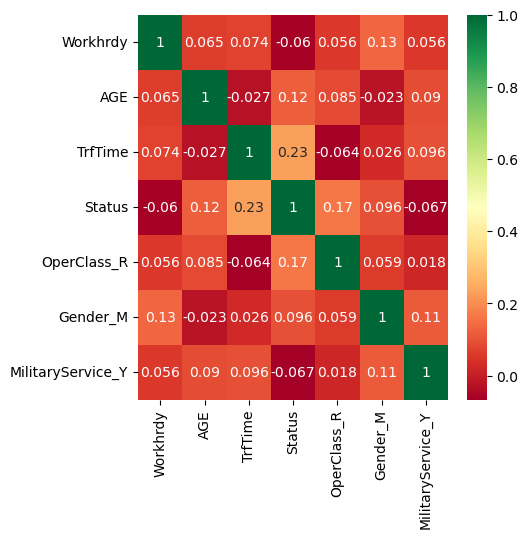

In [18]:
corrmat=df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Fit Model & Prediction

In [69]:
#FineTune Hyperparameter
training_acc=[]
test_acc=[]

neighbors= range(1,30)

for num_neighbors in neighbors:
    Knn_model=KNeighborsClassifier(n_neighbors=num_neighbors)
    Knn_model.fit(transformed_X_train,y_train)
    training_acc.append(Knn_model.score(transformed_X_train,y_train))
    test_acc.append(Knn_model.score(transformed_X_test,y_test))
    
    
    

Text(0.5, 0, 'Number of neighbors')

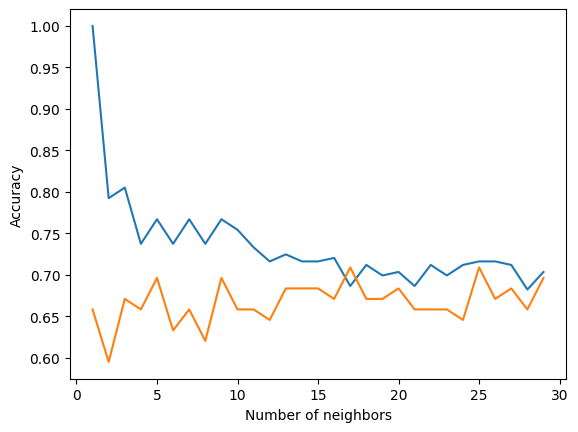

In [70]:
import matplotlib.pyplot as plt
plt.plot(neighbors,training_acc,label = "training accuracy")
plt.plot(neighbors,test_acc, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbors")

In [71]:
# based on the graph above, choose n_neighbors = 17
knn=KNeighborsClassifier(n_neighbors=17)
knn.fit(transformed_X_train,y_train)

KNeighborsClassifier(n_neighbors=17)

In [72]:
pred=knn.predict(transformed_X_test)

# Model Evaluation

In [74]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [75]:
print(confusion_matrix(y_test,pred))

[[ 9 17]
 [ 6 47]]


In [76]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.60      0.35      0.44        26
           1       0.73      0.89      0.80        53

    accuracy                           0.71        79
   macro avg       0.67      0.62      0.62        79
weighted avg       0.69      0.71      0.68        79



# Pickle file for deployment

In [78]:
#Pickling the model file
import pickle
model_path  = os.path.join("pickle_files","knn.pkl")
with open(model_path,'wb') as f:
    pickle.dump(knn,f)
